Image shape: torch.Size([1, 3, 224, 224])
Mask shape : torch.Size([1, 1, 224, 224])
Mask patches shape: torch.Size([1, 196, 256])
Hair region indices: [5, 6, 7, 17, 18, 19, 20, 21, 22, 23, 30, 31, 32, 33, 34, 35, 36, 37, 44, 45, 46, 47, 48, 49, 50, 51, 52, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 73, 74, 79, 80, 81, 86, 87, 94, 95, 100, 101, 108, 109, 114, 115, 123, 128, 129, 137]
Số patch chứa tóc: 56


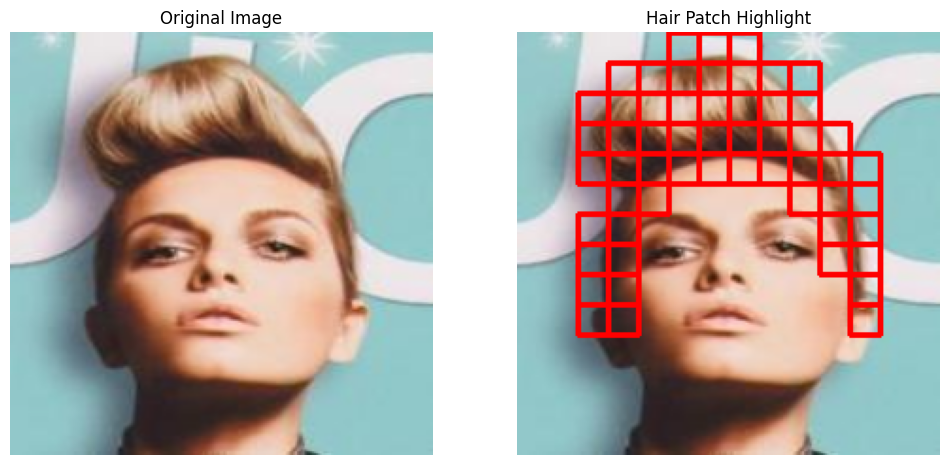

In [25]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import einops

# ==== 1. Đọc ảnh gốc và mask ====
image_path = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/img_align_celeba/000005.jpg"       # ảnh gốc
mask_path  = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000005_hair.png"        # ảnh mask tóc (binary)

image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# kiểm tra mask đọc được không
if mask is None:
    raise FileNotFoundError(f"Không thể đọc được mask từ {mask_path}")
# đọc ảnh gốc (BGR -> RGB)
target_size = (224, 224)
image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
mask  = cv2.resize(mask,  target_size, interpolation=cv2.INTER_NEAREST) 

# đảm bảo mask nhị phân {0,1}
mask = (mask > 0).astype(np.uint8)

# chuyển thành torch tensor
image_t = torch.tensor(image).permute(2,0,1).unsqueeze(0).float()  # (1,3,H,W)
mask_t  = torch.tensor(mask).unsqueeze(0).unsqueeze(0).float()     # (1,1,H,W)

print("Image shape:", image_t.shape)
print("Mask shape :", mask_t.shape)

# ==== 2. Patchify ====
patch_size = 16
B, _, H, W = mask_t.shape
nh, nw = H // patch_size, W // patch_size

# chia mask thành patch
mask_patches = einops.rearrange(
    mask_t,
    "b 1 (nh ph) (nw pw) -> b (nh nw) (ph pw)",
    ph=patch_size, pw=patch_size
)


print("Mask patches shape:", mask_patches.shape)

# ==== 3. Kiểm tra patch nào có tóc ====
has_hair = (mask_patches.sum(dim=-1) > 0)   # (B, num_patches)
hair_region_idx = torch.nonzero(has_hair[0], as_tuple=False).squeeze(1)

print("Hair region indices:", hair_region_idx.tolist())
print("Số patch chứa tóc:", len(hair_region_idx))

# ==== 4. (Optional) Hiển thị ảnh highlight các patch chứa tóc ====
# tạo ảnh overlay: highlight patch có tóc
overlay = image.copy()
for idx in hair_region_idx.tolist():
    row, col = divmod(idx, nw)
    y0, y1 = row*patch_size, (row+1)*patch_size
    x0, x1 = col*patch_size, (col+1)*patch_size
    cv2.rectangle(overlay, (x0,y0), (x1,y1), (255,0,0), 2)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Hair Patch Highlight")
plt.imshow(overlay)
plt.axis("off")
plt.show()


In [26]:
from typing import Dict, List, Tuple, Union

from PIL.Image import Image
from torch import Tensor

from lightly.transforms.torchvision_v2_compatibility import torchvision_transforms as T
from lightly.transforms.utils import IMAGENET_NORMALIZE


class MAETransform:
    """Implements the view augmentation for MAE [0].

    Input to this transform:
        PIL Image or Tensor.

    Output of this transform:
        List of Tensor of length 1.

    Applies the following augmentations by default:
        - Random resized crop
        - Random horizontal flip

    - [0]: Masked Autoencoder, 2021, https://arxiv.org/abs/2111.06377

    Attributes:
        input_size:
            Size of the input image in pixels.
        min_scale:
            Minimum size of the randomized crop relative to the input_size.
        normalize:
            Dictionary with 'mean' and 'std' for torchvision.transforms.Normalize.

    """

    def __init__(
        self,
        input_size: Union[int, Tuple[int, int]] = 224,
        min_scale: float = 0.2,
        normalize: Dict[str, List[float]] = IMAGENET_NORMALIZE,
    ):
        transforms = [
            T.RandomResizedCrop(
                input_size, scale=(min_scale, 1.0), interpolation=3
            ),  # 3 is bicubic
            T.RandomHorizontalFlip(),
            T.ToTensor(),
        ]
        if normalize:
            transforms.append(T.Normalize(mean=normalize["mean"], std=normalize["std"]))

        self.transform = T.Compose(transforms)

    def __call__(self, image: Union[Tensor, Image]) -> List[Tensor]:
        """
        Applies the transforms to the input image.

        Args:
            image:
                The input image to apply the transforms to.

        Returns:
            The transformed image.

        """
        return [self.transform(image)]

In [27]:
import torchvision.transforms.functional as F
import random

def joint_transform(image_pil, mask_pil, size=224, normalize=IMAGENET_NORMALIZE):
    # random crop chung
    i, j, h, w = T.RandomResizedCrop.get_params(image_pil, scale=(1.0, 1.0), ratio=(1.0, 1.0))
    image_pil = F.resized_crop(image_pil, i, j, h, w, (size, size))
    mask_pil  = F.resized_crop(mask_pil, i, j, h, w, (size, size))

    image_pil = F.to_tensor(image_pil)   # (3,H,W)
    mask_pil  = F.to_tensor(mask_pil) 

    # lấy 1 kênh mask
    mask_pil = mask_pil[0:1, :, :] 
    combined = torch.cat([image_pil, mask_pil], dim=0)
    
    # khởi tạo flip transform
    flip = T.RandomHorizontalFlip()
    
    # áp dụng
    combined = flip(combined)
    
    # tách ra
    image_pil = combined[:3, :, :]
    mask_pil  = combined[3:, :, :]

    if normalize:
        norm = T.Normalize(mean=normalize["mean"], std=normalize["std"])
        image_pil = norm(image_pil)

    return image_pil, mask_pil


In [28]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import einops
from PIL import Image
from lightly.transforms import MAETransform

def process_image_and_mask(image_path: str, mask_path: str, input_size: int = 224, patch_size: int = 16):
    """
    Đọc ảnh gốc + mask, transform về cùng size,
    patchify mask -> lấy chỉ số patch có tóc,
    hiển thị ảnh gốc, ảnh transform và overlay highlight patch tóc.
    """
    # ==== 1. Load transform ====
    image_transform = MAETransform(input_size=input_size, min_scale=1.0)
    mask_transform  = MAETransform(input_size=input_size, min_scale=1.0, normalize=None)

    # ==== 2. Đọc ảnh gốc và mask ====
    image_orig = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)   # ảnh gốc để hiển thị
    mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask  = np.stack([mask, mask, mask], axis=-1)  # convert về 3 kênh cho transform

    image = Image.fromarray(image_orig)
    mask  = Image.fromarray(mask)

    #image = image_transform(image)[0]   # (3,H,W)
    #mask  = mask_transform(mask)[0]     # (3,H,W)
    image, mask = joint_transform(image, mask)

    # ==== 3. Chuyển mask về 1 kênh, nhị phân ====
    #mask = mask[0:1, :, :]    # lấy 1 kênh
    mask = (mask > 0)

    image_t = image.unsqueeze(0).float()  # (1,3,H,W)
    mask_t  = mask.unsqueeze(0)           # (1,1,H,W)

    # ==== 4. Patchify mask ====
    B, _, H, W = mask_t.shape
    nh, nw = H // patch_size, W // patch_size

    mask_patches = einops.rearrange(
        mask_t,
        "b 1 (nh ph) (nw pw) -> b (nh nw) (ph pw)",
        ph=patch_size, pw=patch_size
    )

    # ==== 5. Kiểm tra patch nào có tóc ====
    has_hair = (mask_patches.sum(dim=-1) > 0)   # (B, num_patches)
    hair_region_idx = torch.nonzero(has_hair[0], as_tuple=False).squeeze(1)

    # ==== 6. Hiển thị ảnh gốc + ảnh transform + overlay ====
    img_np = image_t[0].permute(1,2,0).cpu().numpy()   # (H,W,3)
    img_np = (img_np * 255).astype(np.uint8)

    overlay = img_np.copy()
    for idx in hair_region_idx.tolist():
        row, col = divmod(idx, nw)
        y0, y1 = row*patch_size, (row+1)*patch_size
        x0, x1 = col*patch_size, (col+1)*patch_size
        cv2.rectangle(overlay, (x0,y0), (x1,y1), (255,0,0), 2)

    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(image_orig)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Transformed Image")
    plt.imshow(img_np)
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Hair Patch Highlight")
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()

    return image_t, mask_t, hair_region_idx


/media/miniconda3/envs/ci/lib/python3.10/site-packages/torchvision/transforms/transforms.py:899: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


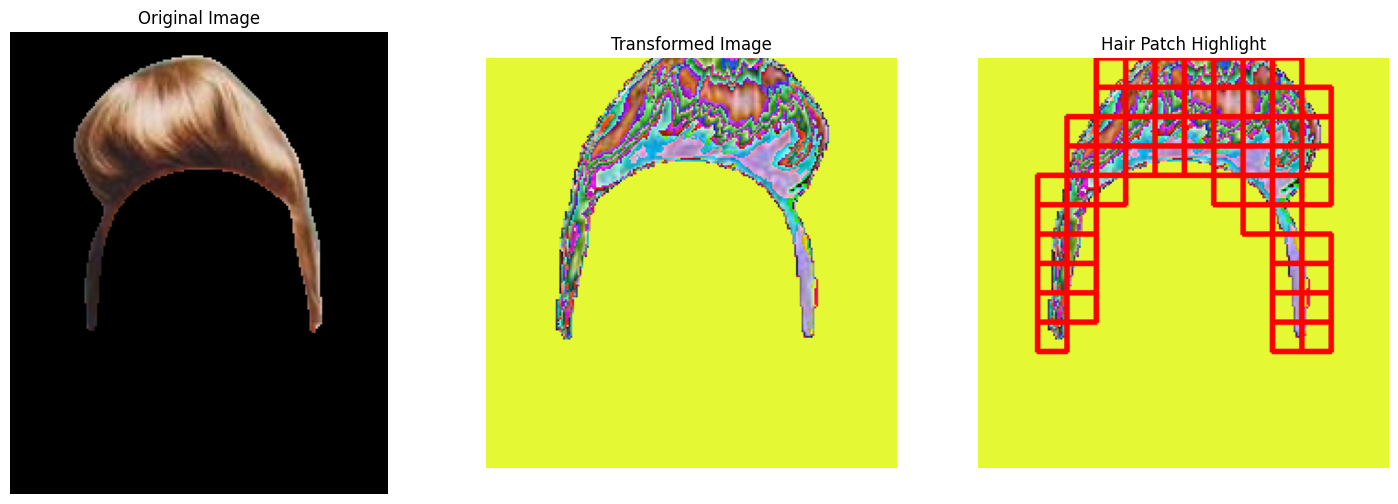

In [29]:
image_path = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000005_hair.png"
mask_path  = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000005_hair.png"


image_t, mask_t, hair_region_idx = process_image_and_mask(image_path, mask_path)


In [30]:
import math
import random

from PIL import ImageFilter, ImageOps
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as F


class RandomResizedCrop(transforms.RandomResizedCrop):
    def __init__(self, cfg, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.args = cfg

    @staticmethod
    def get_params(img, scale, ratio):
        """Get parameters for ``crop`` for a random sized crop.

        Args:
            img (PIL Image or Tensor): Input image.
            scale (list): range of scale of the origin size cropped
            ratio (list): range of aspect ratio of the origin aspect ratio cropped

        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for a random
            sized crop.
        """
        width, height = F.get_image_size(img)
        area = height * width

        log_ratio = torch.log(torch.tensor(ratio))
        for _ in range(10):
            target_area = area * torch.empty(1).uniform_(scale[0], scale[1]).item()
            aspect_ratio = torch.exp(torch.empty(1).uniform_(log_ratio[0], log_ratio[1])).item()

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if 0 < w <= width and 0 < h <= height:
                i1 = torch.randint(0, height - h + 1, size=(1,)).item()
                i2 = torch.randint(0, height - h + 1, size=(1,)).item()
                j1 = torch.randint(0, width - w + 1, size=(1,)).item()
                j2 = torch.randint(0, width - w + 1, size=(1,)).item()

                return i1, j1, i2, j2, h, w

        # Fallback to central crop
        in_ratio = float(width) / float(height)
        if in_ratio < min(ratio):
            w = width
            h = int(round(w / min(ratio)))
        elif in_ratio > max(ratio):
            h = height
            w = int(round(h * max(ratio)))
        else:  # whole image
            w = width
            h = height
        i = (height - h) // 2
        j = (width - w) // 2
        return i, j, i, j, h, w

    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be cropped and resized.

        Returns:
            PIL Image or Tensor: Randomly cropped and resized image.
        """
        i1, j1, i2, j2, h, w = self.get_params(img, self.scale, self.ratio)
        return F.resized_crop(img, i1, j1, h, w, self.size, self.interpolation), \
            F.resized_crop(img, i2, j2, h, w, self.size, self.interpolation), (i2-i1)/h, (j2-j1)/w, h/h, w/w


class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x


class Solarize(object):
    """Solarize augmentation from BYOL: https://arxiv.org/abs/2006.07733"""

    def __call__(self, x):
        return ImageOps.solarize(x)


class SingleRandomResizedCrop(transforms.RandomResizedCrop):
    @staticmethod
    def get_params(img, scale, ratio):
        width, height = F.get_image_size(img)
        area = height * width

        log_ratio = torch.log(torch.tensor(ratio))
        for _ in range(10):
            target_area = area * torch.empty(1).uniform_(scale[0], scale[1]).item()
            aspect_ratio = torch.exp(torch.empty(1).uniform_(log_ratio[0], log_ratio[1])).item()

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if 0 < w <= width and 0 < h <= height:
                i = torch.randint(0, height - h + 1, size=(1,)).item()
                j = torch.randint(0, width - w + 1, size=(1,)).item()
                return i, j, h, w, width

        # fallback central crop
        in_ratio = float(width) / float(height)
        if in_ratio < min(ratio):
            w = width
            h = int(round(w / min(ratio)))
        elif in_ratio > max(ratio):
            h = height
            w = int(round(h * max(ratio)))
        else:
            w, h = width, height
        i = (height - h) // 2
        j = (width - w) // 2
        return i, j, h, w, width

    def forward(self, img, i=None, j=None, h=None, w=None):
        """
        Nếu không truyền (i,j,h,w) thì random, 
        còn nếu truyền thì dùng crop box đó để đồng bộ (ví dụ cho mask).
        """
        if i is None or j is None or h is None or w is None:
            i, j, h, w, width = self.get_params(img, self.scale, self.ratio)
        else:
            width, _ = F.get_image_size(img)

        out = F.resized_crop(img, i, j, h, w, self.size, self.interpolation)
        return out, i, j, h, w, width

    

class RandomHorizontalFlip(transforms.RandomHorizontalFlip):
    def forward(self, img):
        if torch.rand(1) < self.p:
            return F.hflip(img), True
        return img, False

In [31]:
# import torchvision.transforms as transforms
# import torchvision.transforms.functional as F
# import torch
# import math
# import random
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import einops
# from PIL import Image
# import einops

# def get_hair_region_idx(mask_t, patch_size=16):
#     """
#     mask_t: (1,H,W) tensor nhị phân
#     Trả về danh sách index các patch có tóc
#     """
#     B, H, W = 1, mask_t.shape[1], mask_t.shape[2]
#     nh, nw = H // patch_size, W // patch_size

#     mask_patches = einops.rearrange(
#         mask_t.unsqueeze(0),   # (1,1,H,W)
#         "b 1 (nh ph) (nw pw) -> b (nh nw) (ph pw)",
#         ph=patch_size, pw=patch_size
#     )
#     has_hair = (mask_patches.sum(dim=-1) > 0)   # (1, nh*nw)
#     hair_region_idx = torch.nonzero(has_hair[0], as_tuple=False).squeeze(1)
#     return hair_region_idx


# # ===== Custom Flip cho phép truyền quyết định flip =====
# class RandomHorizontalFlip(transforms.RandomHorizontalFlip):
#     def forward(self, img, flip=None):
#         if flip is None:  # random lần đầu
#             flip = torch.rand(1) < self.p
#         if flip:
#             return F.hflip(img), True
#         return img, False


# # ===== Custom Crop cho phép truyền i, j, h, w =====
# class SingleRandomResizedCrop(transforms.RandomResizedCrop):
#     @staticmethod
#     def get_params(img, scale, ratio):
#         width, height = F.get_image_size(img)
#         area = height * width

#         log_ratio = torch.log(torch.tensor(ratio))
#         for _ in range(10):
#             target_area = area * torch.empty(1).uniform_(scale[0], scale[1]).item()
#             aspect_ratio = torch.exp(torch.empty(1).uniform_(log_ratio[0], log_ratio[1])).item()

#             w = int(round(math.sqrt(target_area * aspect_ratio)))
#             h = int(round(math.sqrt(target_area / aspect_ratio)))

#             if 0 < w <= width and 0 < h <= height:
#                 i = torch.randint(0, height - h + 1, size=(1,)).item()
#                 j = torch.randint(0, width - w + 1, size=(1,)).item()
#                 return i, j, h, w, width

#         # fallback center crop
#         in_ratio = float(width) / float(height)
#         if in_ratio < min(ratio):
#             w = width
#             h = int(round(w / min(ratio)))
#         elif in_ratio > max(ratio):
#             h = height
#             w = int(round(h * max(ratio)))
#         else:
#             w = width
#             h = height
#         i = (height - h) // 2
#         j = (width - w) // 2
#         return i, j, h, w, width

#     def forward(self, img, i=None, j=None, h=None, w=None):
#         if i is None or j is None or h is None or w is None:
#             i, j, h, w, W = self.get_params(img, self.scale, self.ratio)
#         else:
#             W, _ = F.get_image_size(img)
#         return F.resized_crop(img, i, j, h, w, self.size, self.interpolation), i, j, h, w, W


# # ===== Augmentation giữ đồng bộ image và mask =====
# class DataAugmentationForSIMWithMask(object):
#     def __init__(self, args):
#         self.args = args

#         self.random_resized_crop = SingleRandomResizedCrop(
#             args.input_size, scale=(args.crop_min, 1.0), interpolation=3
#         )
#         self.random_flip = RandomHorizontalFlip()

#         self.color_transform1 = transforms.Compose([
#             transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)], p=0.8),
#             transforms.RandomGrayscale(p=0.2),
#             transforms.RandomApply([transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0))], p=1.0),
#         ])

#         self.color_transform2 = transforms.Compose([
#             transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)], p=0.8),
#             transforms.RandomGrayscale(p=0.2),
#             transforms.RandomApply([transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0))], p=1.0),
#         ])

#         self.format_transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize(
#                 mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
#             )
#         ])

#     def __call__(self, image, mask):
#         # === 1. Flip đồng bộ ===
#         image1, flip1 = self.random_flip(image)
#         image2, flip2 = self.random_flip(image)
#         mask1, _ = self.random_flip(mask, flip=flip1)
#         mask2, _ = self.random_flip(mask, flip=flip2)

#         # === 2. Crop đồng bộ ===
#         image1, i1, j1, h1, w1, W = self.random_resized_crop(image1)
#         image2, i2, j2, h2, w2, W = self.random_resized_crop(image2)
#         mask1, _, _, _, _, _ = self.random_resized_crop(mask1, i=i1, j=j1, h=h1, w=w1)
#         mask2, _, _, _, _, _ = self.random_resized_crop(mask2, i=i2, j=j2, h=h2, w=w2)

#         # === 3. Color aug chỉ cho ảnh ===
#         color_image1 = self.color_transform1(image1)
#         color_image2 = self.color_transform2(image2)

#         # === 4. To tensor ===
#         image1_t = self.format_transform(color_image1)
#         image2_t = self.format_transform(color_image2)

#         mask1_t = F.to_tensor(mask1)[0:1, :, :].float()
#         mask2_t = F.to_tensor(mask2)[0:1, :, :].float()
#         mask1_t = (mask1_t > 0).float()
#         mask2_t = (mask2_t > 0).float()

#         relative_flip = (flip1 and not flip2) or (flip2 and not flip1)

#         mask1_idx = get_hair_region_idx(mask1_t, patch_size=16)
#         mask2_idx = get_hair_region_idx(mask2_t, patch_size=16)

#         return (image1_t, mask1_t, mask1_idx), \
#             (image2_t, mask2_t, mask2_idx), \
#             (i2 - i1) / h1, (j2 - j1) / w1, h2 / h1, w2 / w1, relative_flip, (W - j1 - j2) / w1



# # ===== Visualization =====
# def visualize_with_mask_aug(image_path, mask_path, aug, patch_size=16):
#     image_orig = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
#     mask_orig  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#     mask_orig  = np.stack([mask_orig, mask_orig, mask_orig], axis=-1)

#     image_pil = Image.fromarray(image_orig)
#     mask_pil  = Image.fromarray(mask_orig)

#     (image1_t, mask1_t, mask1_idx), (image2_t, mask2_t, mask2_idx), *_ = aug(image_pil, mask_pil)
#     print(mask1_idx)
#     print(mask2_idx)

#     def get_overlay(image_t, mask_t):
#         B, _, H, W = mask_t.unsqueeze(0).shape
#         nh, nw = H // patch_size, W // patch_size
#         mask_patches = einops.rearrange(
#             mask_t.unsqueeze(0),
#             "b 1 (nh ph) (nw pw) -> b (nh nw) (ph pw)",
#             ph=patch_size, pw=patch_size
#         )
#         has_hair = (mask_patches.sum(dim=-1) > 0)
#         hair_region_idx = torch.nonzero(has_hair[0], as_tuple=False).squeeze(1)

#         img_np = (image_t.permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)
#         overlay = img_np.copy()
#         for idx in hair_region_idx.tolist():
#             row, col = divmod(idx, nw)
#             y0, y1 = row*patch_size, (row+1)*patch_size
#             x0, x1 = col*patch_size, (col+1)*patch_size
#             cv2.rectangle(overlay, (x0,y0), (x1,y1), (255,0,0), 2)
#         return img_np, overlay

#     img1, overlay1 = get_overlay(image1_t, mask1_t)
#     img2, overlay2 = get_overlay(image2_t, mask2_t)

#     plt.figure(figsize=(20,10))
#     plt.subplot(1,5,1); plt.title("Original"); plt.imshow(image_orig); plt.axis("off")
#     plt.subplot(1,5,2); plt.title("Image1");   plt.imshow(img1);       plt.axis("off")
#     plt.subplot(1,5,3); plt.title("Overlay1"); plt.imshow(overlay1);   plt.axis("off")
#     plt.subplot(1,5,4); plt.title("Image2");   plt.imshow(img2);       plt.axis("off")
#     plt.subplot(1,5,5); plt.title("Overlay2"); plt.imshow(overlay2);   plt.axis("off")
#     plt.show()

#     return (image1_t, mask1_t), (image2_t, mask2_t)


In [32]:
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import torch
import math
import random
import numpy as np
from PIL import Image
import einops


# ===== Custom Flip =====
class RandomHorizontalFlip(transforms.RandomHorizontalFlip):
    def forward(self, img, flip=None):
        if flip is None:
            flip = torch.rand(1) < self.p
        if flip:
            return F.hflip(img), True
        return img, False


# ===== Custom Crop =====
class SingleRandomResizedCrop(transforms.RandomResizedCrop):
    @staticmethod
    def get_params(img, scale, ratio):
        width, height = F.get_image_size(img)
        area = height * width

        log_ratio = torch.log(torch.tensor(ratio))
        for _ in range(10):
            target_area = area * torch.empty(1).uniform_(scale[0], scale[1]).item()
            aspect_ratio = torch.exp(torch.empty(1).uniform_(log_ratio[0], log_ratio[1])).item()

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if 0 < w <= width and 0 < h <= height:
                i = torch.randint(0, height - h + 1, size=(1,)).item()
                j = torch.randint(0, width - w + 1, size=(1,)).item()
                return i, j, h, w, width

        # fallback center crop
        in_ratio = float(width) / float(height)
        if in_ratio < min(ratio):
            w = width
            h = int(round(w / min(ratio)))
        elif in_ratio > max(ratio):
            h = height
            w = int(round(h * max(ratio)))
        else:
            w = width
            h = height
        i = (height - h) // 2
        j = (width - w) // 2
        return i, j, h, w, width

    def forward(self, img, i=None, j=None, h=None, w=None):
        if i is None or j is None or h is None or w is None:
            i, j, h, w, W = self.get_params(img, self.scale, self.ratio)
        else:
            W, _ = F.get_image_size(img)
        return F.resized_crop(img, i, j, h, w, self.size, self.interpolation), i, j, h, w, W


# ===== Helper: patchify mask =====
# def get_hair_region_idx(mask_t, patch_size=16):
#     B, H, W = 1, mask_t.shape[1], mask_t.shape[2]
#     nh, nw = H // patch_size, W // patch_size

#     mask_patches = einops.rearrange(
#         mask_t.unsqueeze(0),
#         "b 1 (nh ph) (nw pw) -> b (nh nw) (ph pw)",
#         ph=patch_size, pw=patch_size
#     )
#     has_hair = (mask_patches.sum(dim=-1) > 0)
#     hair_region_idx = torch.nonzero(has_hair[0], as_tuple=False).squeeze(1)
#     return hair_region_idx

import torch
import einops

def get_hair_region_idx(mask_t, patch_size=16):
    # mask_t: [batch_size, H, W], binary mask of hair region
    B, H, W = mask_t.shape
    nh, nw = H // patch_size, W // patch_size

    # Convert image mask to patch-level mask
    mask_patches = einops.rearrange(
        mask_t.unsqueeze(1),  # Add channel dim
        "b 1 (nh ph) (nw pw) -> b (nh nw) (ph pw)",
        ph=patch_size, pw=patch_size
    )  # [batch_size, num_patches, patch_size*patch_size]

    # Binary mask: 1 if patch contains hair (any pixel > 0), 0 otherwise
    has_hair = (mask_patches.sum(dim=-1) > 0).float()  # [batch_size, num_patches]
    return has_hair


# ===== Augmentation with mask =====
class DataAugmentationForSIMWithMask(object):
    def __init__(self, args):
        self.args = args

        self.random_resized_crop = SingleRandomResizedCrop(
            args.input_size, scale=(args.crop_min, 1.0), interpolation=3
        )
        self.random_flip = RandomHorizontalFlip()

        self.color_transform1 = transforms.Compose([
            transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([
                transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0))
            ], p=1.0),
        ])

        self.color_transform2 = transforms.Compose([
            transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([
                transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0))
            ], p=1.0),
        ])

        # ✅ Positive transform (split thành rotate + blur)
        self.pos_rotation = transforms.RandomRotation(degrees=(-45, 45))
        self.pos_blur = transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5))

        self.format_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            )
        ])

    def __call__(self, image, mask):
        # === 1. Flip đồng bộ ===
        image1, flip1 = self.random_flip(image)
        image2, flip2 = self.random_flip(image)
        mask1, _ = self.random_flip(mask, flip=flip1)
        mask2, _ = self.random_flip(mask, flip=flip2)

        # === 2. Crop đồng bộ ===
        image1, i1, j1, h1, w1, W = self.random_resized_crop(image1)
        image2, i2, j2, h2, w2, W = self.random_resized_crop(image2)
        mask1, _, _, _, _, _ = self.random_resized_crop(mask1, i=i1, j=j1, h=h1, w=w1)
        mask2, _, _, _, _, _ = self.random_resized_crop(mask2, i=i2, j=j2, h=h2, w=w2)

        # === 3. Color aug chỉ cho ảnh ===
        color_image1 = self.color_transform1(image1)
        color_image2 = self.color_transform2(image2)

        # === 4. Positive transform từ image2 + mask2 ===
        angle = random.uniform(-15, 15)
        pos_image = F.rotate(image2, angle)
        pos_image = self.pos_blur(pos_image)  # chỉ blur image
        pos_mask = F.rotate(mask2, angle)     # mask chỉ rotate, không blur

        # === 5. To tensor ===
        image1_t = self.format_transform(color_image1)
        image2_t = self.format_transform(color_image2)
        pos_image_t = self.format_transform(pos_image)

        mask1_t = (F.to_tensor(mask1)[0:1, :, :] > 0).float()
        mask2_t = (F.to_tensor(mask2)[0:1, :, :] > 0).float()
        pos_mask_t = (F.to_tensor(pos_mask)[0:1, :, :] > 0).float()

        # === 6. Hair idx ===
        mask1_idx = get_hair_region_idx(mask1_t, patch_size=16)
        mask2_idx = get_hair_region_idx(mask2_t, patch_size=16)
        pos_mask_idx = get_hair_region_idx(pos_mask_t, patch_size=16)

        relative_flip = (flip1 and not flip2) or (flip2 and not flip1)

        return (image1_t, mask1_t, mask1_idx), \
               (image2_t, mask2_t, mask2_idx), \
               (pos_image_t, pos_mask_t, pos_mask_idx), \
               (i2 - i1) / h1, (j2 - j1) / w1, h2 / h1, w2 / w1, relative_flip, (W - j1 - j2) / w1

def visualize_with_mask_aug(image_path, mask_path, aug, patch_size=16):
    # ==== 1. Load ảnh gốc + mask ====
    image_orig = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    mask_orig  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_orig  = np.stack([mask_orig, mask_orig, mask_orig], axis=-1)

    image_pil = Image.fromarray(image_orig)
    mask_pil  = Image.fromarray(mask_orig)

    # ==== 2. Augmentation ====
    (image1_t, mask1_t, mask1_idx), \
    (image2_t, mask2_t, mask2_idx), \
    (pos_image_t, pos_mask_t, pos_mask_idx), *_ = aug(image_pil, mask_pil)

    print(f"mask1_idx: {mask1_idx.shape} => ", mask1_idx)
    print(f"mask2_idx: {mask2_idx.shape} => ", mask2_idx)
    print(f"pos_mask_idx: {pos_mask_idx.shape} => ", pos_mask_idx)

    print("image1: ", image1_t.shape)
    print("image2: ", image2_t.shape)
    print("image3: ", pos_image_t.shape)

    # ==== 3. Overlay helper ====
    def get_overlay(image_t, mask_t):
        B, _, H, W = mask_t.unsqueeze(0).shape
        nh, nw = H // patch_size, W // patch_size
        mask_patches = einops.rearrange(
            mask_t.unsqueeze(0),
            "b 1 (nh ph) (nw pw) -> b (nh nw) (ph pw)",
            ph=patch_size, pw=patch_size
        )
        has_hair = (mask_patches.sum(dim=-1) > 0)
        hair_region_idx = torch.nonzero(has_hair[0], as_tuple=False).squeeze(1)

        img_np = (image_t.permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)
        overlay = img_np.copy()
        for idx in hair_region_idx.tolist():
            row, col = divmod(idx, nw)
            y0, y1 = row*patch_size, (row+1)*patch_size
            x0, x1 = col*patch_size, (col+1)*patch_size
            cv2.rectangle(overlay, (x0,y0), (x1,y1), (255,0,0), 2)
        return img_np, overlay

    # ==== 4. Render overlays ====
    img1, overlay1 = get_overlay(image1_t, mask1_t)
    img2, overlay2 = get_overlay(image2_t, mask2_t)
    img_pos, overlay_pos = get_overlay(pos_image_t, pos_mask_t)

    # ==== 5. Plot ====
    plt.figure(figsize=(25,10))
    plt.subplot(1,7,1); plt.title("Original");  plt.imshow(image_orig); plt.axis("off")
    plt.subplot(1,7,2); plt.title("Image1");    plt.imshow(img1);       plt.axis("off")
    plt.subplot(1,7,3); plt.title("Overlay1");  plt.imshow(overlay1);   plt.axis("off")
    plt.subplot(1,7,4); plt.title("Image2");    plt.imshow(img2);       plt.axis("off")
    plt.subplot(1,7,5); plt.title("Overlay2");  plt.imshow(overlay2);   plt.axis("off")
    plt.subplot(1,7,6); plt.title("PosImage");  plt.imshow(img_pos);    plt.axis("off")
    plt.subplot(1,7,7); plt.title("PosOverlay");plt.imshow(overlay_pos);plt.axis("off")
    plt.show()

    return (image1_t, mask1_t), (image2_t, mask2_t), (pos_image_t, pos_mask_t), (mask1_idx, mask2_idx, pos_mask_idx)


mask1_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
         1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
         1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.]])
mask2_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.

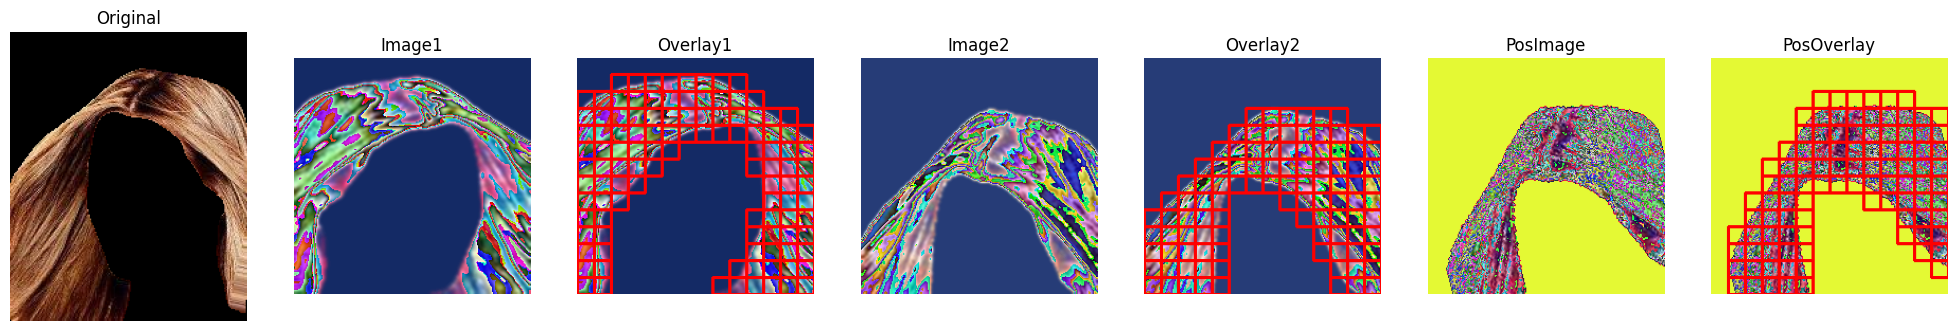

In [33]:
args = type('', (), {})()  # tạo args giả
args.input_size = 224
args.crop_min = 0.5

aug = DataAugmentationForSIMWithMask(args)

mask_path  = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000001_hair.png"
image_path = mask_path

(image1_t, mask1_t), (image2_t, mask2_t), _,  (mask1_idx, mask2_idx, pos_mask_idx)= visualize_with_mask_aug(image_path, mask_path, aug)


mask1_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
         1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
         0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
mask2_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.

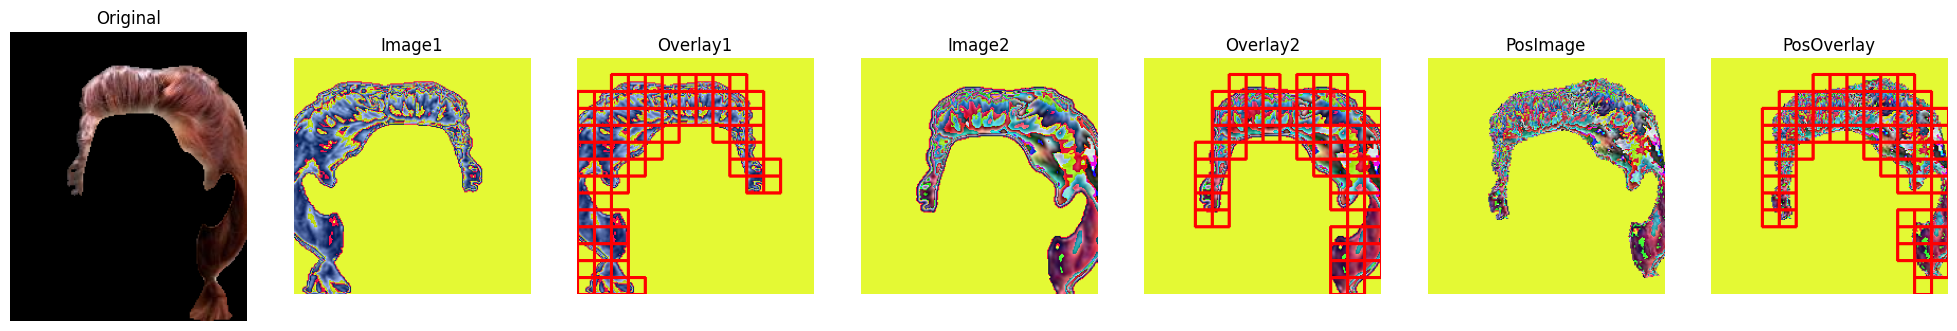

In [34]:
mask_path  = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000002_hair.png"
image_path = mask_path

(image1_t, mask1_t), (image2_t, mask2_t),_,  (mask1_idx, mask2_idx, pos_mask_idx) = visualize_with_mask_aug(image_path, mask_path, aug)


mask1_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
         1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
         1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
mask2_idx: torch.Size([1, 196]) =>  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1.

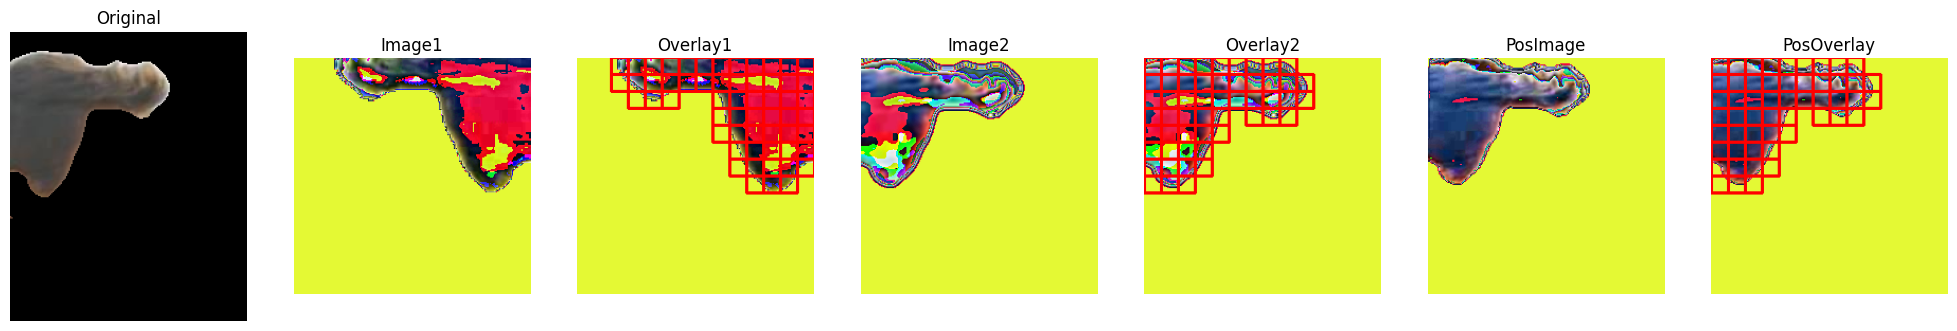

In [35]:
mask_path  = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000003_hair.png"
image_path = mask_path

(image1_t, mask1_t), (image2_t, mask2_t), _,  (mask1_idx, mask2_idx, pos_mask_idx) = visualize_with_mask_aug(image_path, mask_path, aug)


mask1_idx: torch.Size([1, 196]) =>  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
         0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
         1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1.,
         1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
         1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
         0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
         1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.]])
mask2_idx: torch.Size([1, 196]) =>  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1.

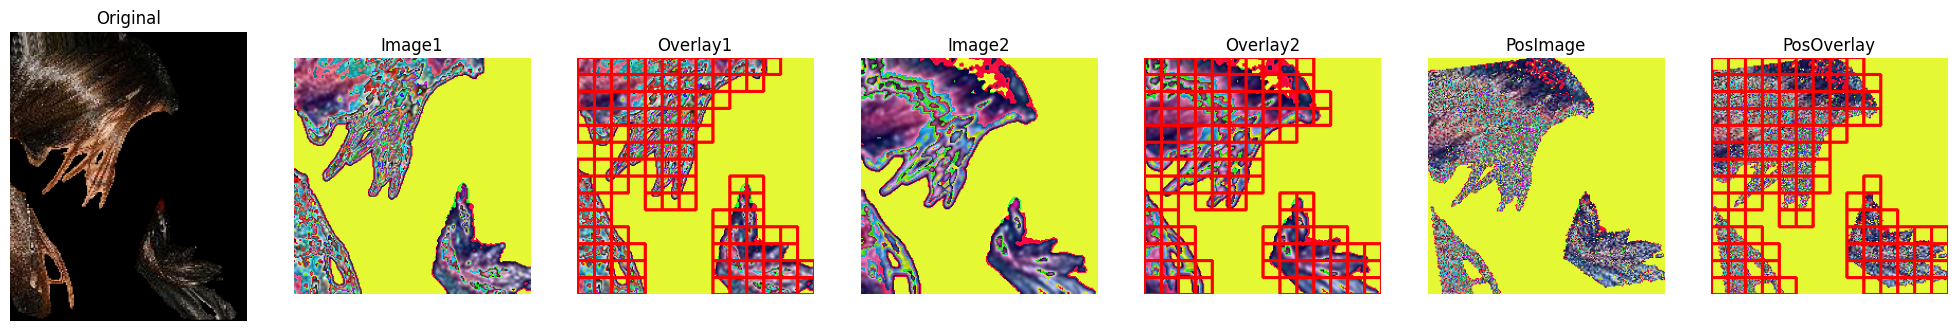

In [36]:
mask_path  = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000004_hair.png"
image_path = mask_path

(image1_t, mask1_t), (image2_t, mask2_t), _,  (mask1_idx, mask2_idx, pos_mask_idx) = visualize_with_mask_aug(image_path, mask_path, aug)


mask1_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
         1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
         0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
mask2_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 1., 1., 1., 1., 1., 1.

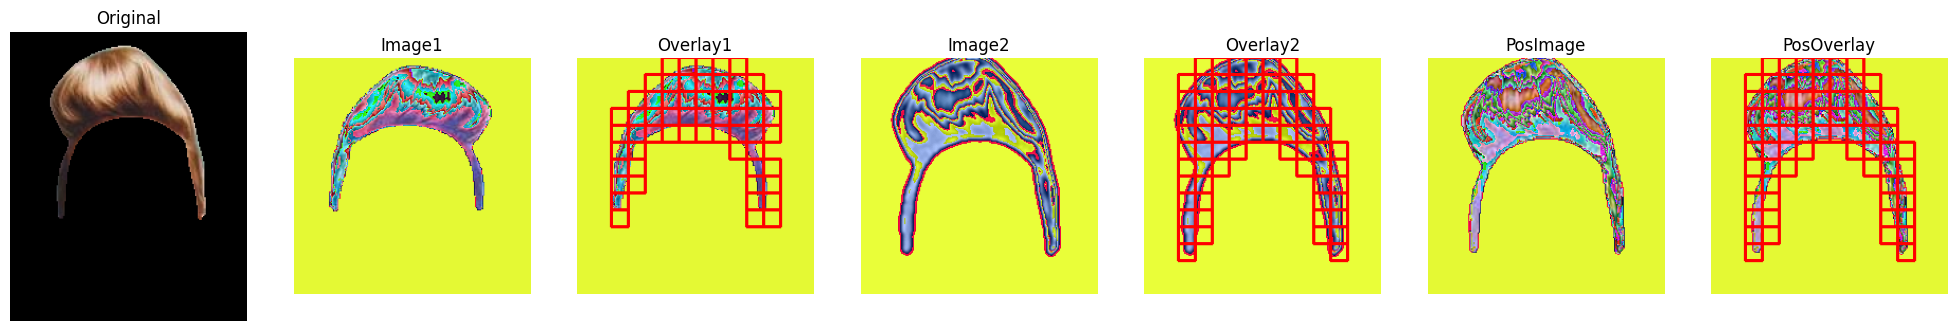

In [37]:
mask_path  = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000005_hair.png"
image_path = mask_path

(image1_t, mask1_t), (image2_t, mask2_t), _,  (mask1_idx, mask2_idx, pos_mask_idx) = visualize_with_mask_aug(image_path, mask_path, aug)


mask1_idx: torch.Size([1, 196]) =>  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
         1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.,
         1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
         1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
         1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
         1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
         1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.]])
mask2_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 0., 0., 0., 1., 1., 1.

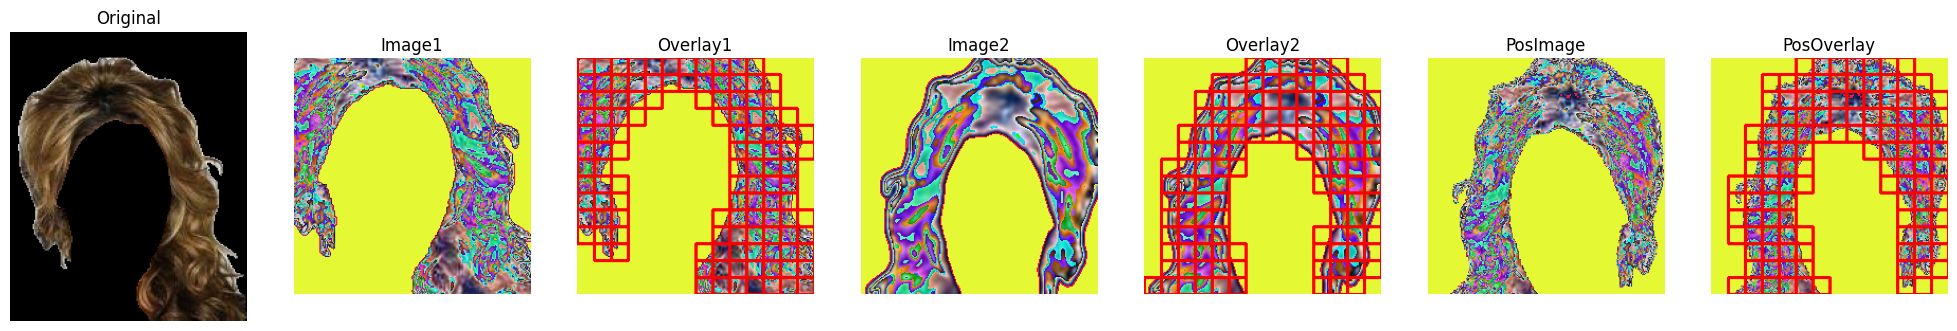

In [38]:
mask_path  = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000006_hair.png"
image_path = mask_path

(image1_t, mask1_t), (image2_t, mask2_t), _,  (mask1_idx, mask2_idx, pos_mask_idx) = visualize_with_mask_aug(image_path, mask_path, aug)


mask1_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
         1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
         0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
         1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
mask2_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 1., 1., 1., 1., 1., 1.

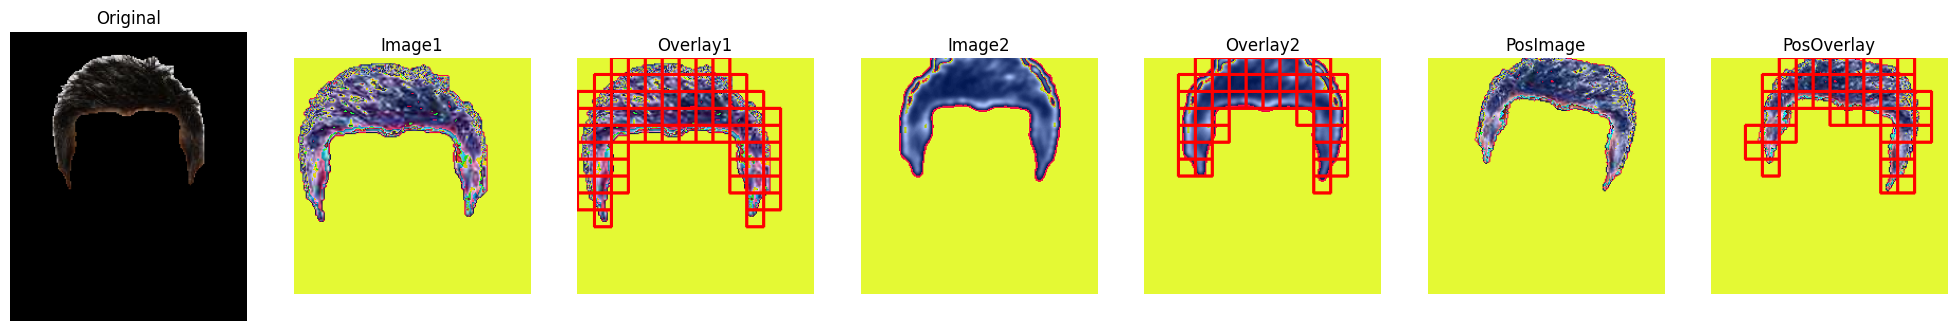

In [39]:
mask_path  = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000007_hair.png"
image_path = mask_path

(image1_t, mask1_t), (image2_t, mask2_t), _,  (mask1_idx, mask2_idx, pos_mask_idx) = visualize_with_mask_aug(image_path, mask_path, aug)


mask1_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
         1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
         0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
         0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
         0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
mask2_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.

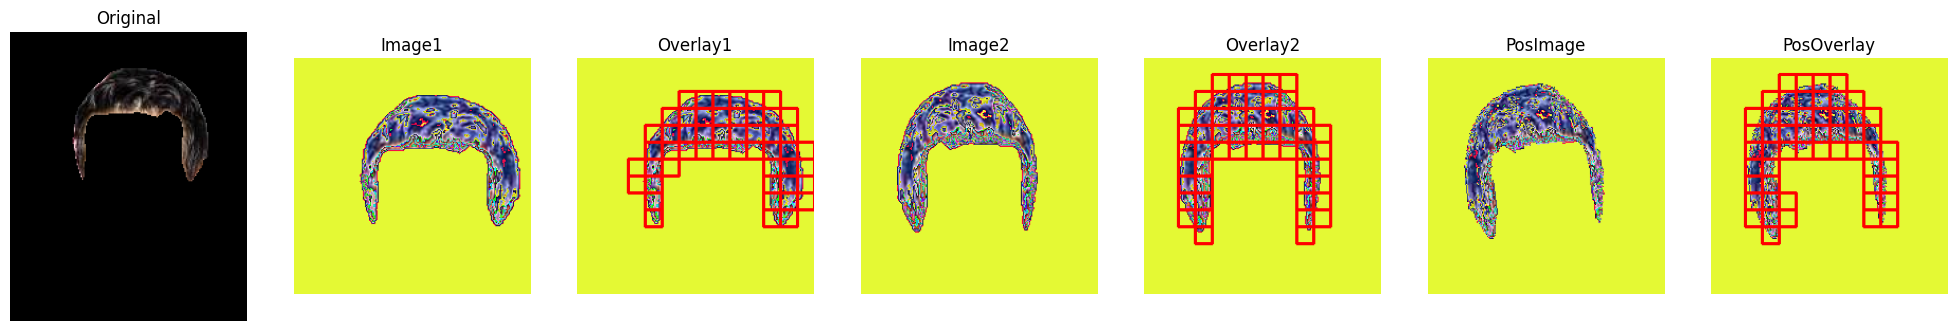

In [40]:
mask_path  = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000008_hair.png"
image_path = mask_path

(image1_t, mask1_t), (image2_t, mask2_t), _,  (mask1_idx, mask2_idx, pos_mask_idx) = visualize_with_mask_aug(image_path, mask_path, aug)


mask1_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0.,
         1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
         0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
         0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
         1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0.,
         0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.]])
mask2_idx: torch.Size([1, 196]) =>  tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1.

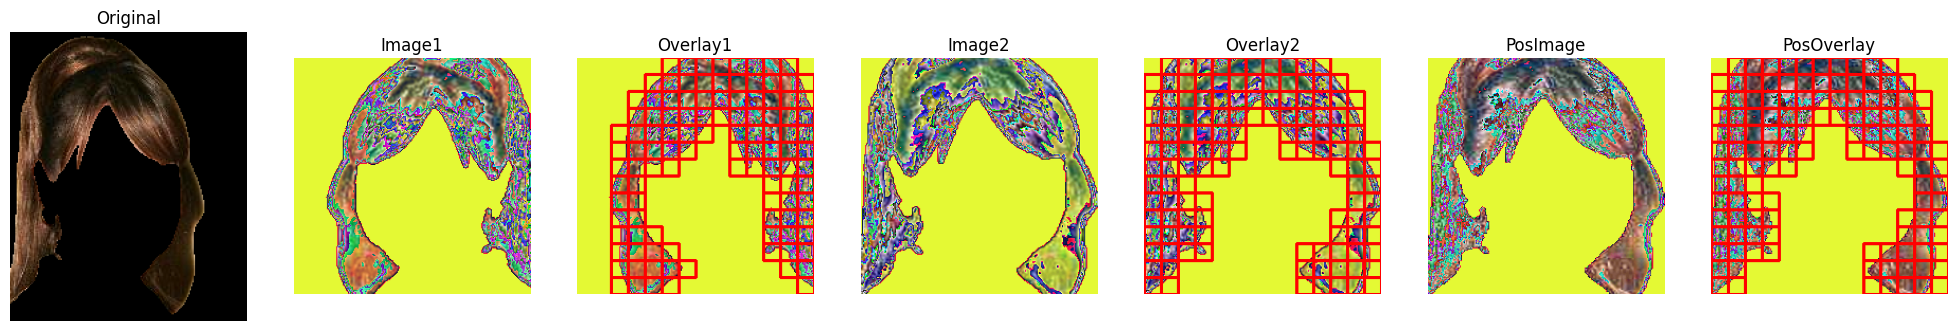

In [41]:
mask_path  = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000009_hair.png"
image_path = mask_path

(image1_t, mask1_t), (image2_t, mask2_t), _,  (mask1_idx, mask2_idx, pos_mask_idx) = visualize_with_mask_aug(image_path, mask_path, aug)


mask1_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
         1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
         0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
         0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
         1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
         0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
         1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.]])
mask2_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 1., 1., 1., 1., 1., 1.

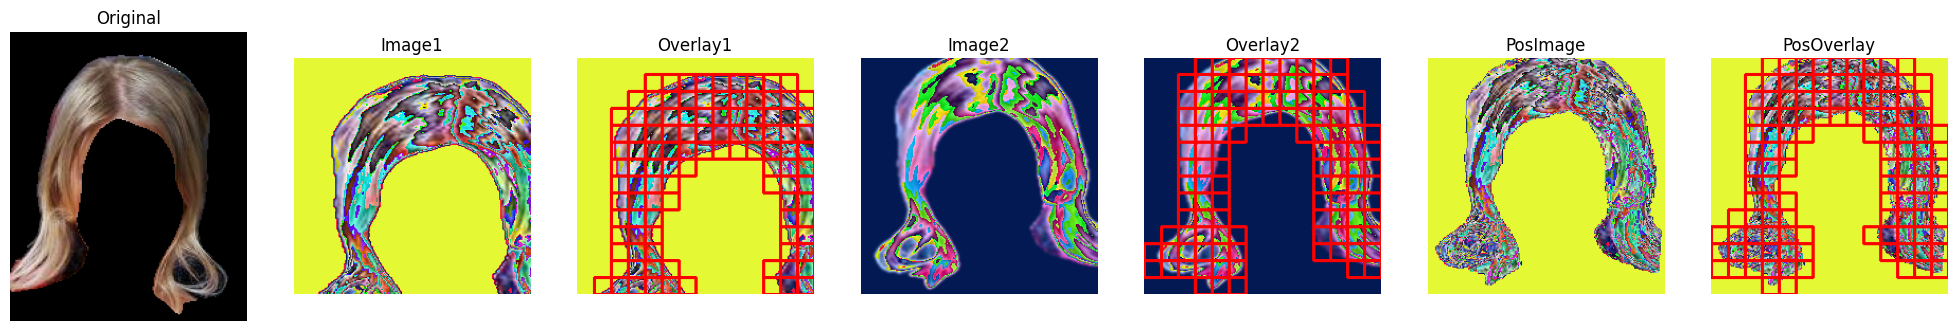

In [42]:
mask_path  = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000010_hair.png"
image_path = mask_path

(image1_t, mask1_t), (image2_t, mask2_t), _,  (mask1_idx, mask2_idx, pos_mask_idx) = visualize_with_mask_aug(image_path, mask_path, aug)


mask1_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
         0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
         0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
         0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]])
mask2_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 0., 0., 1., 1., 0., 0.

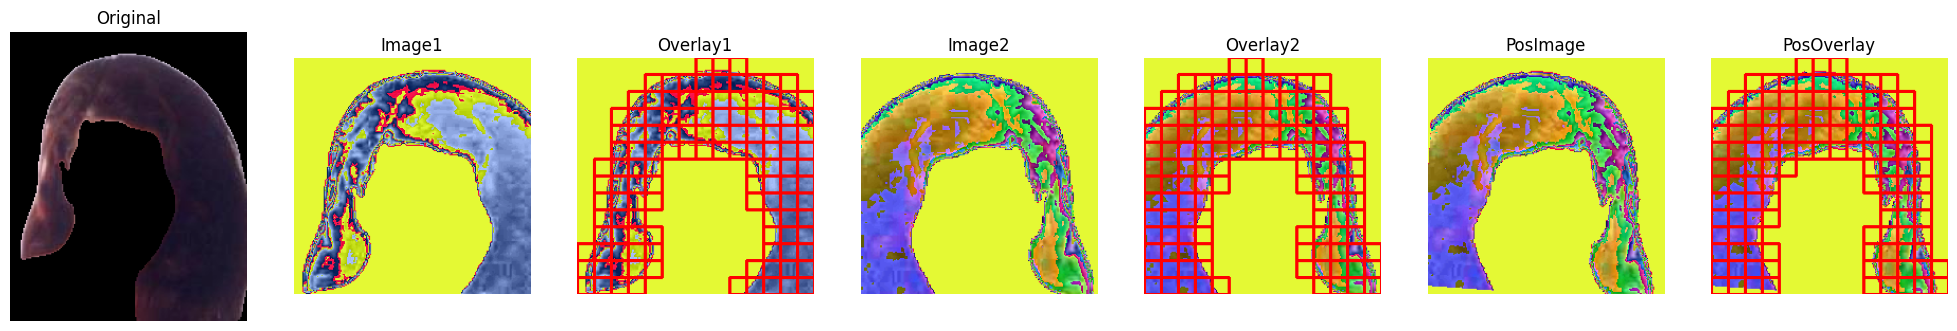

In [43]:
mask_path  = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000011_hair.png"
image_path = mask_path

(image1_t, mask1_t), (image2_t, mask2_t), _,  (mask1_idx, mask2_idx, pos_mask_idx) = visualize_with_mask_aug(image_path, mask_path, aug)


mask1_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
         1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
         0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
         1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
         0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
         1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
         0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
mask2_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.

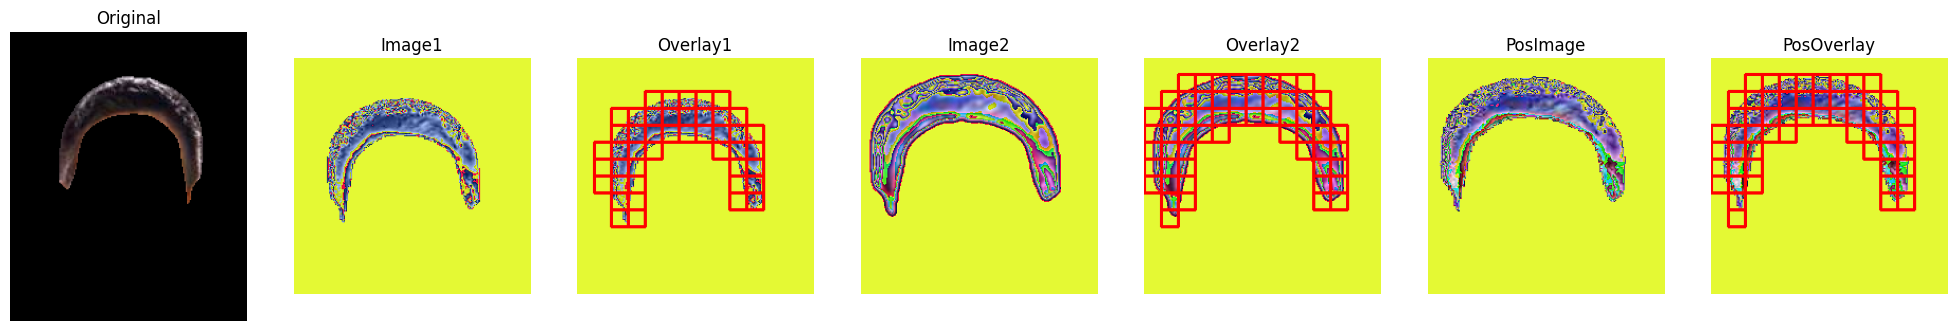

In [44]:
mask_path  = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000012_hair.png"
image_path = mask_path

(image1_t, mask1_t), (image2_t, mask2_t), _,  (mask1_idx, mask2_idx, pos_mask_idx) = visualize_with_mask_aug(image_path, mask_path, aug)


mask1_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
         1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
mask2_idx: torch.Size([1, 196]) =>  tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0.

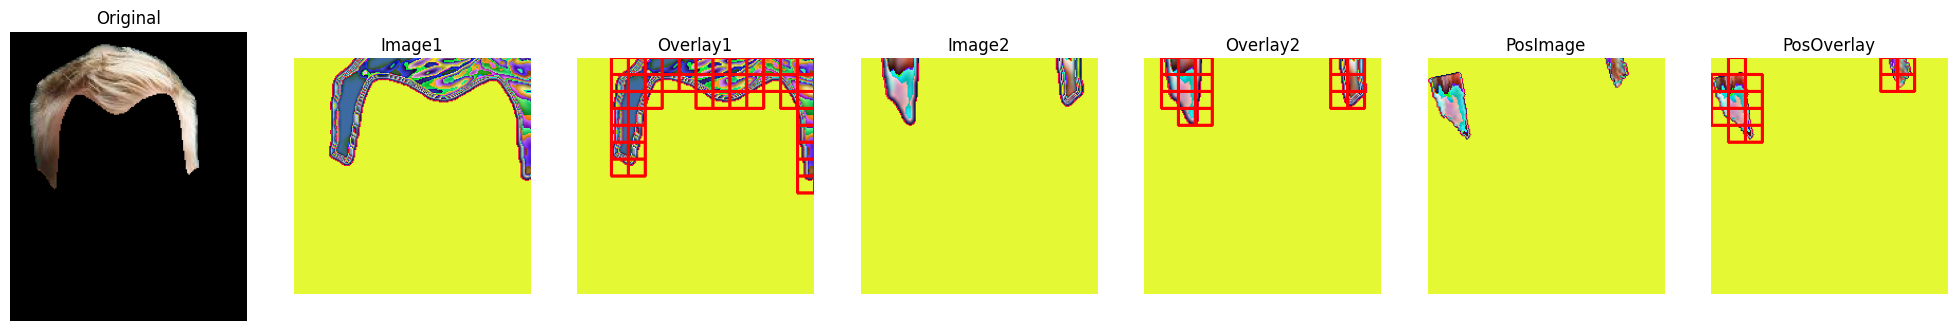

In [45]:
mask_path  = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000013_hair.png"
image_path = mask_path

(image1_t, mask1_t), (image2_t, mask2_t), _,  (mask1_idx, mask2_idx, pos_mask_idx) = visualize_with_mask_aug(image_path, mask_path, aug)


mask1_idx: torch.Size([1, 196]) =>  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0.,
         0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
         0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
mask2_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1.

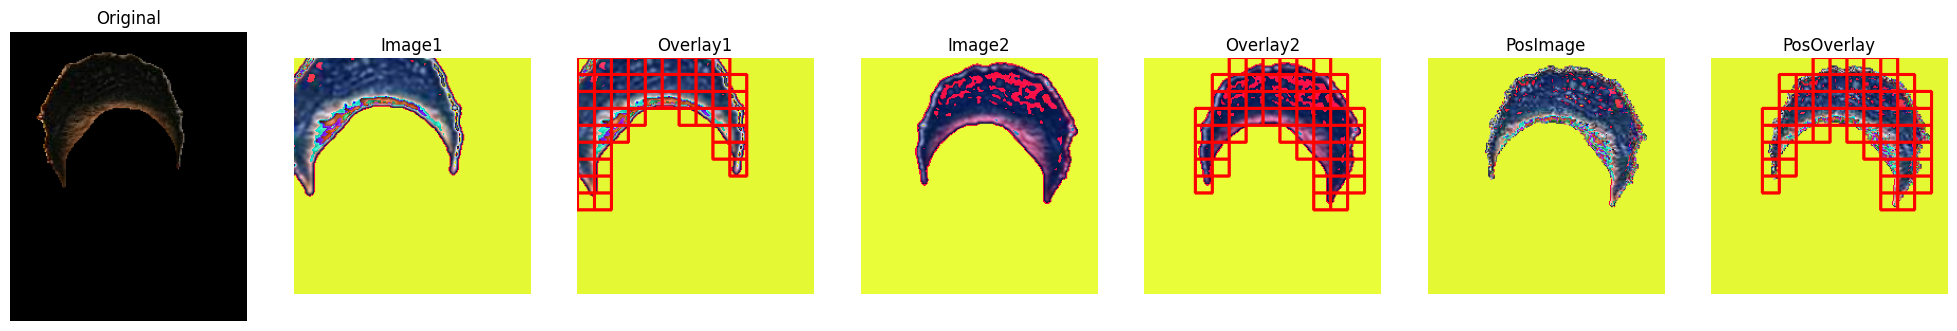

In [46]:
mask_path  = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000014_hair.png"
image_path = mask_path

(image1_t, mask1_t), (image2_t, mask2_t), _,  (mask1_idx, mask2_idx, pos_mask_idx) = visualize_with_mask_aug(image_path, mask_path, aug)


mask1_idx: torch.Size([1, 196]) =>  tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
         0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
         0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
         1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
mask2_idx: torch.Size([1, 196]) =>  tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1.

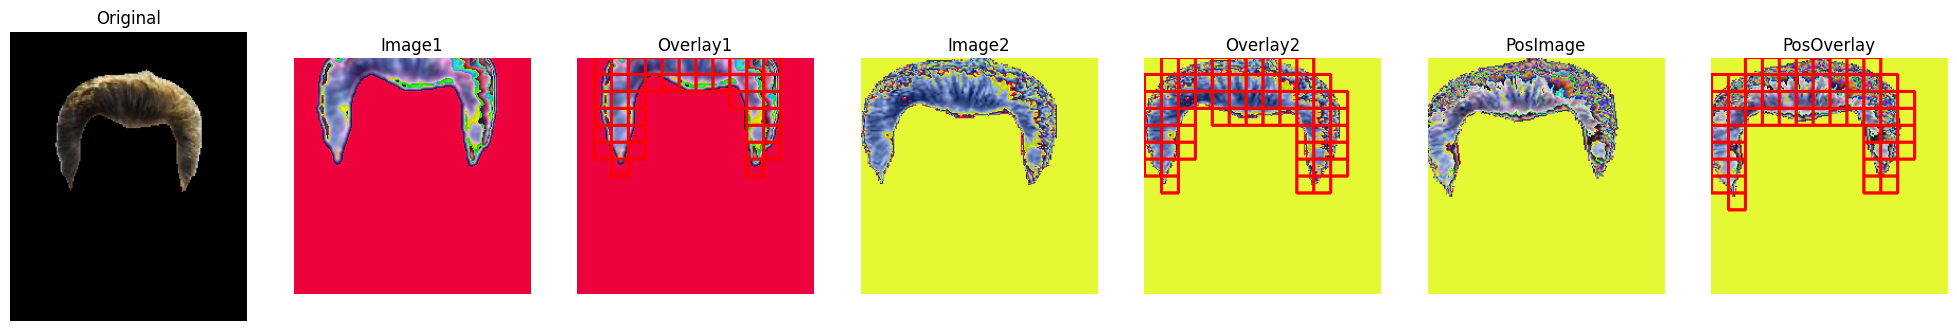

In [47]:
mask_path  = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000015_hair.png"
image_path = mask_path

(image1_t, mask1_t), (image2_t, mask2_t), _,  (mask1_idx, mask2_idx, pos_mask_idx) = visualize_with_mask_aug(image_path, mask_path, aug)


mask1_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
         1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
mask2_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1.

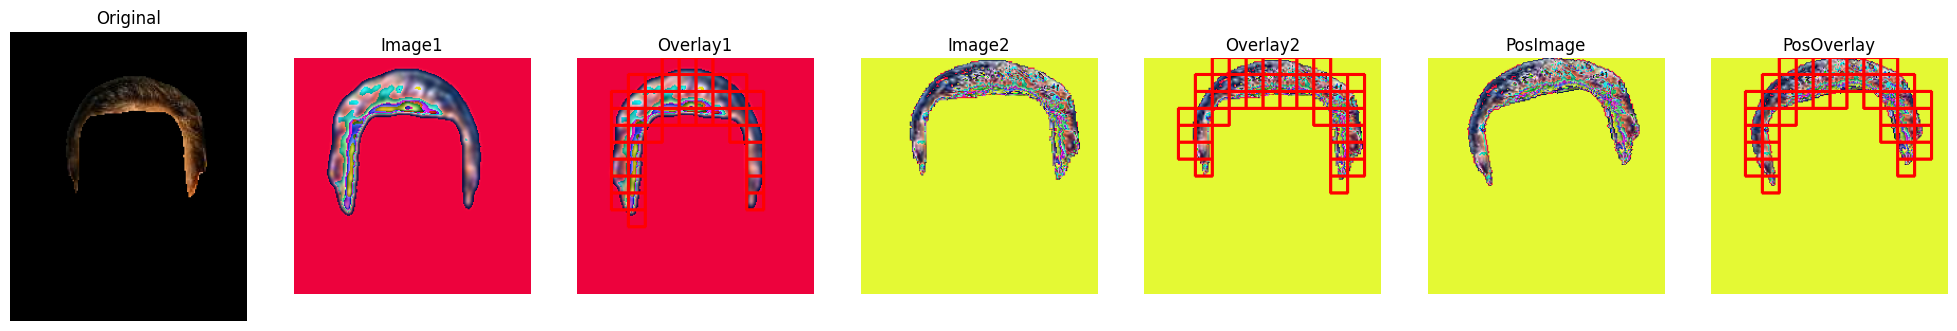

In [48]:
mask_path  = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000016_hair.png"
image_path = mask_path

(image1_t, mask1_t), (image2_t, mask2_t), _,  (mask1_idx, mask2_idx, pos_mask_idx) = visualize_with_mask_aug(image_path, mask_path, aug)


mask1_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
mask2_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.

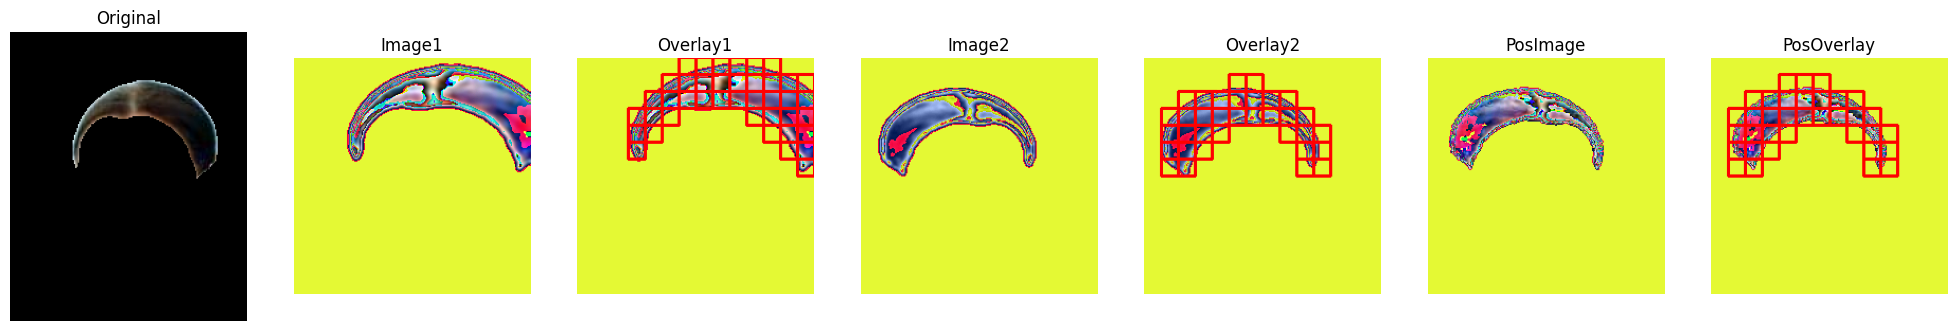

In [49]:
mask_path  = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000017_hair.png"
image_path = mask_path

(image1_t, mask1_t), (image2_t, mask2_t), _,  (mask1_idx, mask2_idx, pos_mask_idx) = visualize_with_mask_aug(image_path, mask_path, aug)


mask1_idx: torch.Size([1, 196]) =>  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
         1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0.,
         0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]])
mask2_idx: torch.Size([1, 196]) =>  tensor([[0., 1., 1., 1., 1., 0., 0., 0., 0.

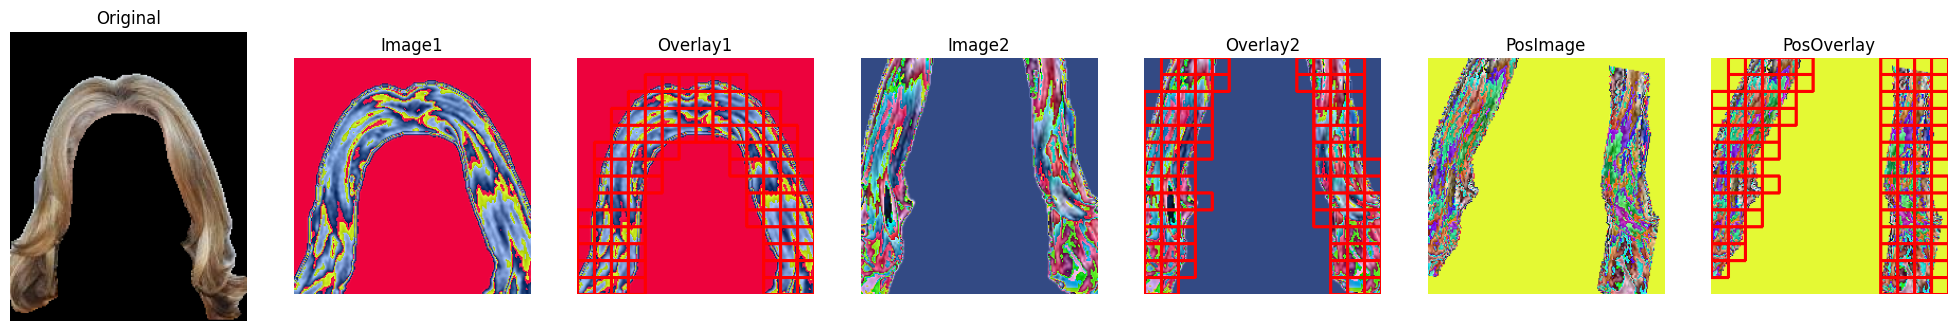

In [50]:
mask_path  = "/mnt/mmlab2024nas/thanhnd_student/QuocAnh/FCIR/Baselines/Composed-Image-Retrieval/experiments/HairClassification/data/hair_regions/000018_hair.png"
image_path = mask_path

(image1_t, mask1_t), (image2_t, mask2_t), _,  (mask1_idx, mask2_idx, pos_mask_idx) = visualize_with_mask_aug(image_path, mask_path, aug)


In [51]:
torch.Size([32, 197, 768])

torch.Size([32, 197, 768])

In [52]:
import torch

a = torch.randn(32, 197, 768)
a.shape

torch.Size([32, 197, 768])

In [56]:
hair_mask = torch.randint(low=0, high=2, size=(32, 196, 1)).squeeze(2)
print("hair mask: ", hair_mask.shape)
max_patches=100
device="cpu"

hair mask:  torch.Size([32, 196])


In [57]:
hair_mask

tensor([[1, 1, 0,  ..., 1, 0, 0],
        [0, 1, 1,  ..., 0, 1, 0],
        [0, 0, 1,  ..., 1, 1, 1],
        ...,
        [0, 0, 1,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0]])

In [59]:
import torch

# hair_mask: [batch_size, num_patches], binary (1 for hair patches, 0 otherwise)
# for i, blk in enumerate(self.vit.blocks[:-1]):
#     tokens = blk(tokens)  # [batch_size, num_patches + 1, dim]

tokens = torch.randn(32, 197, 768)

batch_size, _, dim = tokens.shape
cls_token = tokens[:, 0:1, :]  # [batch_size, 1, dim]
patch_tokens = tokens[:, 1:, :]  # [batch_size, num_patches, dim]

# Pad hair patches to fixed length (vectorized)
num_hair_patches = hair_mask.sum(dim=1).long()  # [batch_size]
print("Num hair patches: ", num_hair_patches)
max_patches = min(num_hair_patches.max(), max_patches)
print("Max patches: ", max_patches)
hair_patches_padded = torch.zeros(batch_size, max_patches, dim, device=device)
attn_mask = torch.ones(batch_size, 1 + max_patches, 1 + max_patches, device=device) * float('-inf')

attn_mask[:, :, 0] = 0  # CLS attends to all
attn_mask[:, 0, :] = 0  # All attend to CLS
print("attention mask: ", attn_mask.shape, attn_mask)

valid_indices = torch.zeros(batch_size, max_patches, dtype=torch.long, device=device)
for b in range(batch_size):
    num_valid = min(num_hair_patches[b], max_patches)
    if num_valid > 0:
        valid_indices[b, :num_valid] = hair_mask[b].nonzero(as_tuple=True)[0][:num_valid]
        hair_patches_padded[b, :num_valid] = patch_tokens[b, valid_indices[b, :num_valid]]
        attn_mask[b, :, 1:1 + num_valid] = 0
        attn_mask[b, 1:1 + num_valid, :] = 0

x_input_L = torch.cat([cls_token, hair_patches_padded], dim=1)  # [batch_size, 1 + max_patches, dim]

# Apply Mask-Guided Attention at layer L
# last_layer = self.vit.blocks[-1]
# x_norm = last_layer.norm1(x_input_L)
# attn_output = last_layer.attn(x_norm, attn_mask=attn_mask)  # timm Attention
# tokens = x_input_L + last_layer.dropout(attn_output)
# tokens = tokens + last_layer.mlp(last_layer.norm2(tokens))

Num hair patches:  tensor([ 99,  91,  87,  89,  85, 110, 102, 102,  87,  87, 100, 104,  90,  92,
         90,  95,  97,  93,  95,  96, 115,  94, 105, 100,  88,  96,  94,  94,
         92,  96, 100, 100])
Max patches:  100
attention mask:  torch.Size([32, 101, 101]) tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., -inf, -inf,  ..., -inf, -inf, -inf],
         [0., -inf, -inf,  ..., -inf, -inf, -inf],
         ...,
         [0., -inf, -inf,  ..., -inf, -inf, -inf],
         [0., -inf, -inf,  ..., -inf, -inf, -inf],
         [0., -inf, -inf,  ..., -inf, -inf, -inf]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., -inf, -inf,  ..., -inf, -inf, -inf],
         [0., -inf, -inf,  ..., -inf, -inf, -inf],
         ...,
         [0., -inf, -inf,  ..., -inf, -inf, -inf],
         [0., -inf, -inf,  ..., -inf, -inf, -inf],
         [0., -inf, -inf,  ..., -inf, -inf, -inf]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., -inf, -inf,  ..., -inf, -inf, -inf],
         [0., -inf